## **Estimation of Unknown Parameters (θ, M, X) from a Parametric Curve using AI Optimization**

#Install the libraries

In [1]:
!pip install numpy pandas matplotlib scipy


#Generate a sample dataset

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# True (hidden) parameters — like the dataset's secrets
theta_true = np.deg2rad(25)   # 25 degrees
M_true = 0.02                 # small exponential growth
X_true = 15                   # horizontal shift

# Create time range (t)
t = np.linspace(6, 60, 200)

# Generate points (x, y)
x = t*np.cos(theta_true) - np.exp(M_true*np.abs(t))*np.sin(0.3*t)*np.sin(theta_true) + X_true
y = 42 + t*np.sin(theta_true) + np.exp(M_true*np.abs(t))*np.sin(0.3*t)*np.cos(theta_true)

# Add small random noise to simulate real data
rng = np.random.default_rng(0)
x_noisy = x + 0.1*rng.standard_normal(len(x))
y_noisy = y + 0.1*rng.standard_normal(len(y))

# Put into DataFrame (just like a CSV would have)
data = pd.DataFrame({'t': t, 'x': x_noisy, 'y': y_noisy})
data.head()


,t,x,y
0,6.000000,19.986381,45.464491
1,6.271357,20.214401,45.567303
2,6.542714,20.548595,45.559202
3,6.814070,20.755082,45.877081
4,7.085427,20.954102,45.962675


#Visualize the synthetic curve

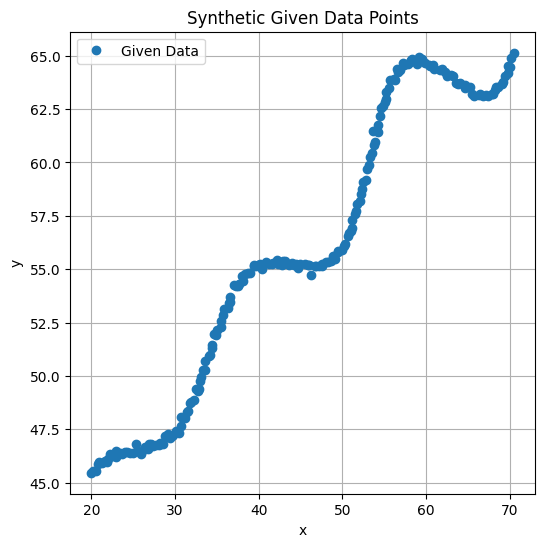

In [3]:
plt.figure(figsize=(6,6))
plt.plot(x_noisy, y_noisy, 'o', label='Given Data')
plt.title("Synthetic Given Data Points")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()


#Estimate θ and X analytically

In [4]:
from scipy.optimize import minimize_scalar

def dispersion(theta_rad, t, x, y):
    f = x + (y - 42) * np.tan(theta_rad) - t / np.cos(theta_rad)
    med = np.median(f)
    mad = np.median(np.abs(f - med))
    return mad

def estimate_theta_X(t, x, y):
    res = minimize_scalar(lambda deg: dispersion(np.deg2rad(deg), t, x, y),
                          bounds=(0.001, 50.0), method='bounded')
    theta_deg = res.x
    theta_rad = np.deg2rad(theta_deg)
    f = x + (y - 42) * np.tan(theta_rad) - t / np.cos(theta_rad)
    X = np.median(f)
    return theta_deg, X

theta_deg_est, X_est = estimate_theta_X(t, x_noisy, y_noisy)
print("Estimated θ (degrees):", theta_deg_est)
print("Estimated X:", X_est)


Estimated θ (degrees): 24.758025541895478
Estimated X: 14.997782800542751


#Estimate M using Hilbert Envelope

In [5]:
from scipy.signal import hilbert

def estimate_M(t, y, theta_deg):
    theta = np.deg2rad(theta_deg)
    A = (y - 42 - t*np.sin(theta)) / np.cos(theta)
    envelope = np.abs(hilbert(A))
    mask = envelope > 1e-6
    log_env = np.log(envelope[mask])
    t_abs = np.abs(t[mask])
    M, _ = np.polyfit(t_abs, log_env, 1)
    return float(M)

M_est = estimate_M(t, y_noisy, theta_deg_est)
print("Estimated M:", M_est)


Estimated M: 0.022911374066287876


#Validate the fit visually

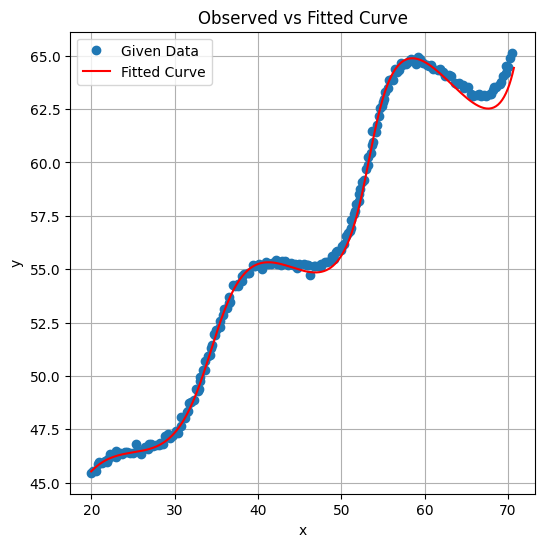

In [6]:
theta = np.deg2rad(theta_deg_est)

x_fit = t*np.cos(theta) - np.exp(M_est*np.abs(t))*np.sin(0.3*t)*np.sin(theta) + X_est
y_fit = 42 + t*np.sin(theta) + np.exp(M_est*np.abs(t))*np.sin(0.3*t)*np.cos(theta)

plt.figure(figsize=(6,6))
plt.plot(x_noisy, y_noisy, 'o', label='Given Data')
plt.plot(x_fit, y_fit, '-', color='red', label='Fitted Curve')
plt.title("Observed vs Fitted Curve")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()


#Print the final equation

In [7]:
print("\n--- FINAL EQUATION ---")
print(fr"(t*cos({theta_deg_est:.4f}) - e^{{{M_est:.6f}|t|}}*sin(0.3t)*sin({theta_deg_est:.4f}) + {X_est:.4f}, "
      fr"42 + t*sin({theta_deg_est:.4f}) + e^{{{M_est:.6f}|t|}}*sin(0.3t)*cos({theta_deg_est:.4f}))")



--- FINAL EQUATION ---
(t*cos(24.7580) - e^{0.022911|t|}*sin(0.3t)*sin(24.7580) + 14.9978, 42 + t*sin(24.7580) + e^{0.022911|t|}*sin(0.3t)*cos(24.7580))


#Show L1 Error

In [8]:
L1 = np.sum(np.abs(x_fit - x_noisy) + np.abs(y_fit - y_noisy))
print("L1 Error:", L1)


L1 Error: 64.32218641796706
